In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
import itertools
import faiss  # make faiss available
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook 
from torchvision import datasets, models, transforms
import torch
import logging
from PIL import Image

from data.where2buyit_dataset import Where2BuyItDataset
from ai.combined_model import CombinedVectorizer
from data.data_set_loaders import load_where2buy_it_data_set

In [2]:
index_file = 'searchable.index'
batch_size = 16
embedding_size = 64

In [76]:
df = load_where2buy_it_data_set()
df_search = df.loc[df.name == 'query']
df = df.loc[df.name != 'query']
df.count()

2020-02-05 20:05:37,349 : INFO : Loading where2buy it data set









Parsing files: 100%|██████████| 16352/16352 [00:00<00:00, 710602.89it/s][A


name        12241
product     12241
category    12241
file        12241
dtype: int64

In [4]:
model = CombinedVectorizer(embedding_size,'/home/cenk/Downloads/trunk_best.pth', '/home/cenk/Downloads/embedder_best.pth')

In [65]:
transformation = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(227),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = Where2BuyItDataset(df, transformation, factorize=False, use_id=True)

In [16]:
index = faiss.IndexFlatL2(embedding_size)
index = faiss.IndexIDMap(index)

for sample, label in tqdm_notebook(dataset, desc='Vectorizing images'):
    vector = model(sample.unsqueeze(0)).detach().numpy()
    index.add_with_ids(vector, np.array([label]).astype('int64') )
faiss.write_index(index, 'searchable.index')

/home/cenk/.pyenv/versions/ai/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [26]:
def get_image(img_path):
    with open(img_path, 'rb') as f:
        with Image.open(f) as img:
            img = img.convert('RGB')
            img = transformation(img)
    return img

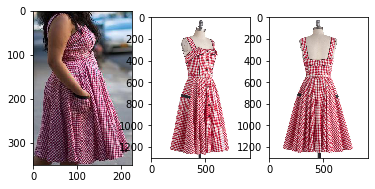

query
0.028612595


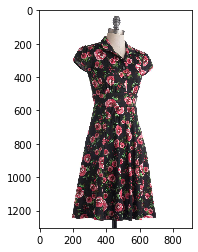

0.02872904


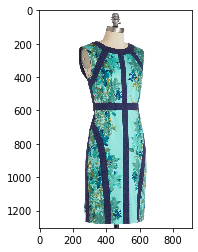

0.028769819


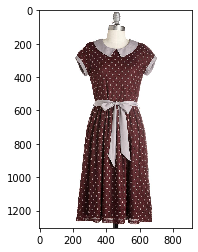

0.028888881


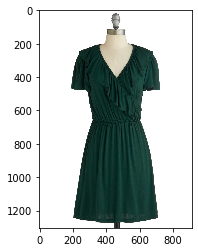

0.029122792


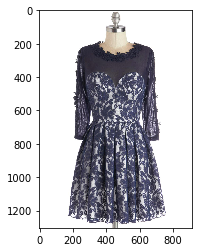

In [74]:
query_path = df_search.sample(1)
samples_to_find = query_path['product'].values[0]
samples_to_find = df.loc[df['product'] == samples_to_find]['file'].values
query_path = query_path['file'].values[0]
# display images
fig, ax = plt.subplots(1,3)

ax[0].imshow(Image.open(query_path))
ax[1].imshow(Image.open(samples_to_find[0]))
ax[2].imshow(Image.open(samples_to_find[1]))
plt.show()
print('query')

img = get_image(query_path)
img = model(img.unsqueeze(0))
img = img.detach().numpy()
distances, ids = index.search(img, 5)
ids = [df.loc[df.name == str(img_id)].file.values[0] for img_id in ids[0]]

for distance, img_path  in zip(distances[0], ids):
    plt.imshow(Image.open(img_path))
    print(distance)
    plt.show()

In [34]:
df.loc[df.name == '61547'].file.values[0]

'/home/cenk/Research/data-sets/where2buyit/photos/footwear/13688/61547.jpg'